In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import json
from torchvision import transforms as T
from torchvision.datasets import CocoDetection
from hcmus.integrate.rpn import YoloRegionProposal
from hcmus.integrate.classifier import Classifier
from hcmus.integrate.pipeline import ModelPipeline

transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

In [ ]:
rpn = YoloRegionProposal(run_id="1dc43b73ab2746b9881567302952f795")
classifier = Classifier(run_id='415b1f0c9b8640d9848e0fc470528ecc')
pipeline = ModelPipeline(rpn,classifier, transforms)

In [ ]:
split_name = "val"
dataset_dir = f"/Volumes/Cucumber/Projects/datasets/curated/hcmus-iid-2/{split_name}"
ann_path = f"{dataset_dir}/annotations_{split_name}.json"
dataset = CocoDetection(
    root=f"{dataset_dir}/images",
    annFile=ann_path
)
cat2label = json.load(open(ann_path))["categories"]
cat2label = {x["id"]: x["name"] for x in cat2label}
label2cat = {v: k for k, v in cat2label.items()}

In [ ]:
def convert_to_coco_format(predictions, category_mapping=None):
    """
    Convert predictions to COCO format.

    Args:
        predictions: List of prediction dictionaries
        category_mapping: Dictionary mapping pred_label to category_id
                         If None, uses pred_idx or assigns default IDs

    Returns:
        List of COCO format dictionaries
    """
    coco_results = []

    for pred in predictions:
        # Convert box format from [x1, y1, x2, y2] to [x, y, width, height]
        x1, y1, x2, y2 = pred['box']
        bbox = [x1, y1, x2 - x1, y2 - y1]
        image_id = pred['image_id']
        score = pred['score']

        # Determine category_id
        if category_mapping and pred['pred_label'] in category_mapping:
            category_id = category_mapping[pred['pred_label']]
        elif pred['pred_idx'] != -1:
            category_id = pred['pred_idx']
        else:
            category_id = 101

        coco_results.append({
            'image_id': image_id,
            'category_id': category_id,
            'bbox': bbox,
            'score': score
        })


    return coco_results

In [ ]:
from PIL import ImageOps

predictions = []
anns = []
for i, (image, ann) in enumerate(dataset):
    image = ImageOps.exif_transpose(image)
    result = pipeline.forward(image)
    image_id = ann[0].get("image_id")
    for item in result:
        item["image_id"] = image_id
    predictions.extend(result)
    anns.extend(ann)
predictions = convert_to_coco_format(predictions, label2cat)

In [ ]:
import pandas as pd
df = pd.DataFrame(predictions)
df_ann = pd.DataFrame(anns)
print(len(df), len(df_ann))

In [ ]:
df_gt = df_ann
df_dt = df

df_gt = df_gt.groupby(by=["image_id", "category_id"]).agg(
    count_gt=pd.NamedAgg(column="category_id", aggfunc="count")
).reset_index()

df_dt = df_dt.groupby(by=["image_id", "category_id"]).agg(
    count_dt=pd.NamedAgg(column="category_id", aggfunc="count")
).reset_index()

In [ ]:
df_stats = pd.merge(df_gt, df_dt, on=["image_id", "category_id"], how="left")
df_stats = df_stats.fillna({"count_dt": 0})

df_stats["diff"] = df_stats["count_dt"] - df_stats["count_gt"]

In [ ]:
df_stats.sort_values(by=["diff"], ascending=False)

In [ ]:
import math
print(f"RMSE: {math.sqrt((df_stats['diff'] ** 2).mean())}")

In [ ]:
df1 = df.groupby("image_id").agg(
    count_dt=pd.NamedAgg(column="category_id", aggfunc="count")
).reset_index()
df2 = df_ann.groupby("image_id").agg(
    count_gt=pd.NamedAgg(column="category_id", aggfunc="count")
).reset_index()


In [ ]:
from hcmus.utils import viz_utils

image, _ = dataset[260]
image = ImageOps.exif_transpose(image)
result = pipeline.forward(image)
boxes = [x["box"] for x in result]
viz_utils.draw_boxes(image, boxes)

In [ ]:
with open("predictions.json", "w") as f:
    json.dump(predictions, f)

In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Step 1: Load ground truth annotations
coco_gt = COCO(ann_path)

# Step 3: Load results
coco_dt = coco_gt.loadRes("predictions.json")

# Step 4: Run evaluation
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


In [ ]:
"""
Yolo8n + Classifier:
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.251
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.299
RMSE: 11.48

Yolo11n + Classifier
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.306
RMSE: 11.59

---
Yolo8s + Classifier:
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.306
 11.305632996931234

Yolo11n + Classifier
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.306


"""

In [1]:
from hcmus.integrate.rpn import YoloRegionProposal

In [2]:
model = YoloRegionProposal("a7998392672747ae958208aad3cf8b9d")

/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
result = model("/Users/keith/Desktop/a0fc79a5d1de80f4c715bb5c78795952.jpeg")


image 1/1 /Users/keith/Desktop/a0fc79a5d1de80f4c715bb5c78795952.jpeg: 480x640 34 objects, 46.8ms
Speed: 1.5ms preprocess, 46.8ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)


In [7]:
from hcmus.utils import viz_utils
from PIL import Image

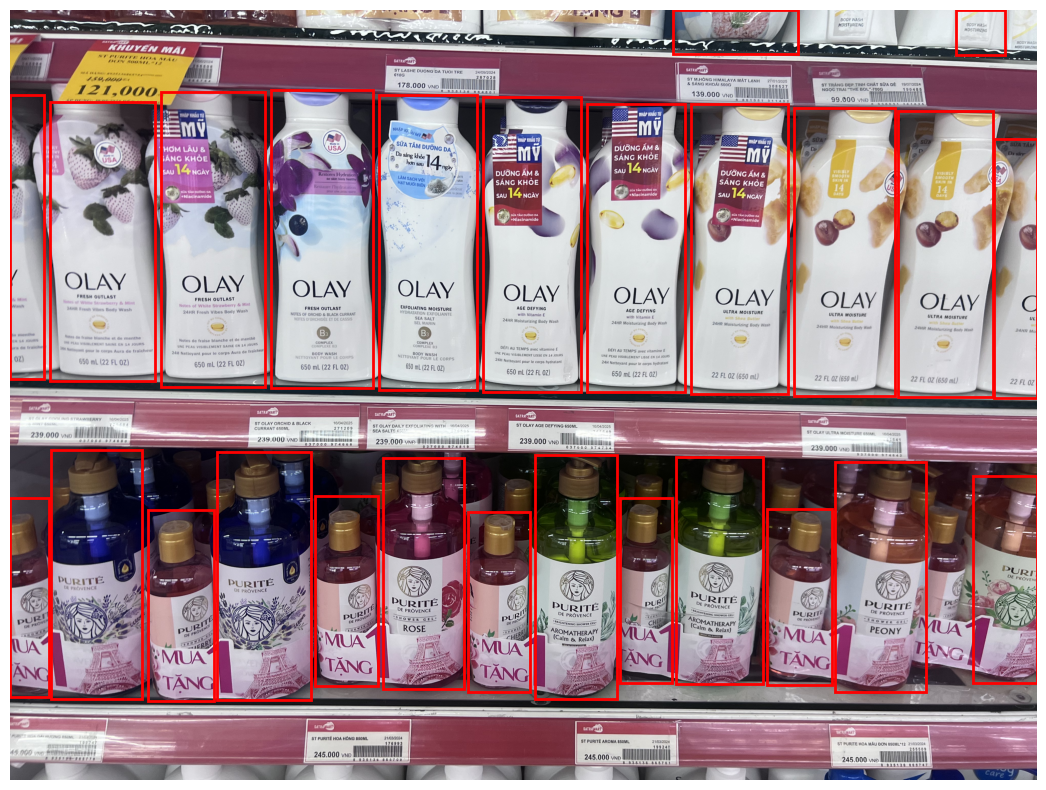

In [8]:
image = Image.open("/Users/keith/Desktop/a0fc79a5d1de80f4c715bb5c78795952.jpeg")
viz_utils.draw_boxes(image, result[0])